# VARモデル復習


# 1. VARモデルとは

VAR(p)モデル（$p$はラグ次数）は、このベクトル$Y_t$が、それ自身の$p$期前までの過去の値の線形関数としてモデル化できると仮定する。
$$
Y_t = c + A_1 Y_{t-1} + A_2 Y_{t-2} + \dots + A_p Y_{t-p} + u_t
$$


$Y_t$: 時点$t$における$K \times 1$の内生変数のベクトル。
$c$: $K \times 1$の切片（定数項）のベクトル。
$p$: ラグ次数。モデルがどれだけ過去まで遡って影響を考慮するかを決定する、最も重要なハイパーパラメータ。
$A_i$: $K \times K$の係数行列（ラグ$i$における$Y_{t-i}$が$Y_t$に与える影響）。
$u_t$: $K \times 1$の誤差項のベクトル。これは「ショック」または「イノベーション」と呼ばれ、平均が0で、時点間で相関せず（系列相関なし）、共分散行列$\Sigma_u$を持つホワイトノイズであると仮定される。
VARの核心は$A_i$行列にある。
例えば、$K=2$（変数1, 変数2）、$p=1$のVAR(1)モデルを考える。

$$
\begin{pmatrix} Y_{1,t} \\ Y_{2,t} \end{pmatrix} = \begin{pmatrix} c_1 \\ c_2 \end{pmatrix} + \begin{pmatrix} a_{11,1} & a_{12,1} \\ a_{21,1} & a_{22,1} \end{pmatrix} \begin{pmatrix} Y_{1,t-1} \\ Y_{2,t-1} \end{pmatrix} + \begin{pmatrix} u_{1,t} \\ u_{2,t} \end{pmatrix}
$$


この行列を展開すると、2つの方程式が得られる。

$Y_{1,t} = c_1 + a_{11,1} Y_{1,t-1} + a_{12,1} Y_{2,t-1} + u_{1,t}$

$Y_{2,t} = c_2 + a_{21,1} Y_{1,t-1} + a_{22,1} Y_{2,t-1} + u_{2,t}$

1番目の方程式は、「変数1の現在の値は、1期前の自分自身の値（$Y_{1,t-1}$）と、1期前の変数2の値（$Y_{2,t-1}$）によって決まる」ことを示す。$a_{12,1}$が0でなければ、変数2から変数1へのフィードバックが存在することになる。
VARモデルの推定とは、これら$K \times K \times p$個の係数（$A_i$行列の全要素）と$K$個の定数項（$c$）をデータから推定するプロセス。

# 2. VARモデルの前提
* **定常性**
* **線形**


# 3. VARモデル構築例

* 米国の「実質GDP(realgdp)」、「実質個人消費支出(realcons)、「実質国内総投資(realinv)」の３変数間の関係性を分析

## 3-1. データ準備

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
mdata = sm.datasets.macrodata.load_pandas().data

# 日付インデックスセット
mdata_dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly_dates = mdata_dates['year'] + "Q" + mdata_dates["quarter"]
mdata.index = pd.PeriodIndex(quarterly_dates, freq="Q").to_timestamp("Q")

variables = ["realgdp", "realcons", "realinv"]
mdata = mdata[variables]

,realgdp,realcons,realinv
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722


<Axes: >

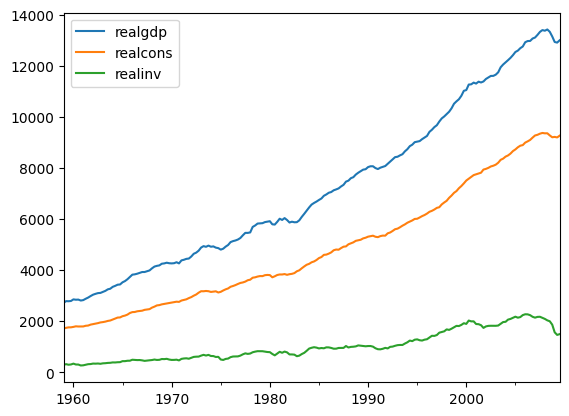

In [3]:
display(mdata.head())
mdata.plot()

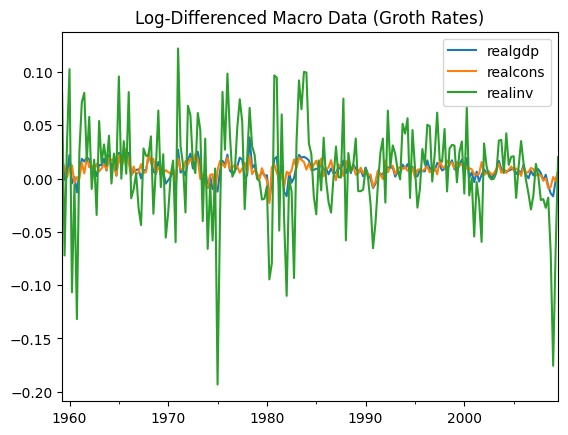

In [4]:
# 変化率による定常化
data = np.log(mdata).diff().dropna()

data.plot(title='Log-Differenced Macro Data (Groth Rates)')
plt.show()

## 3-2. 定常性確認

In [5]:
# 定常性検定

def adf_test(series, name=""):
    """ADF検定関数"""
    print(f"---ADF Test for: {name}---")
    # adfullerの戻り値（ADS statistic, p-value, lags used, num of observations, critical vales, ...）
    result = adfuller(series.dropna())

    adf_stat   = result[0]
    p_value    = result[1]
    usedlag    = result[2]
    nobs       = result[3]
    crit_values = result[4]
    icbest     = result[5]
    
    print(f"ADF statistic : {adf_stat:.4f}")
    print(f"p-value       : {p_value:.4f}")
    print(f"lags used     : {usedlag}")
    print(f"nobs          : {nobs}")
    print("Critical Values:")
    for key, value in crit_values.items():
        print(f"   {key}: {value:.4f}")

    # p値に基づく解釈
    if p_value <= 0.05:
        print(f"Result: Stationary (p-value <= 0.05). We reject the null hypothesis (H0).")
    else:
        print(f"Result: Non-Stationary (p-value > 0.05). We fail to reject the null hypothesis (H0).")

# 定常性チェック
for name in data.columns:
    adf_test(data[name], name=name)

---ADF Test for: realgdp---
ADF statistic : -6.9729
p-value       : 0.0000
lags used     : 1
nobs          : 200
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
Result: Stationary (p-value <= 0.05). We reject the null hypothesis (H0).
---ADF Test for: realcons---
ADF statistic : -4.9920
p-value       : 0.0000
lags used     : 2
nobs          : 199
Critical Values:
   1%: -3.4636
   5%: -2.8762
   10%: -2.5746
Result: Stationary (p-value <= 0.05). We reject the null hypothesis (H0).
---ADF Test for: realinv---
ADF statistic : -12.2190
p-value       : 0.0000
lags used     : 0
nobs          : 201
Critical Values:
   1%: -3.4633
   5%: -2.8760
   10%: -2.5745
Result: Stationary (p-value <= 0.05). We reject the null hypothesis (H0).


## 3-3. ラグ次数探索

In [6]:
# 最適なラグ次数(p)の探索 (aicを利用)

model = VAR(data)

print("---Lag Order Selection---")
lag_selection_results = model.select_order(maxlags=12)

print(lag_selection_results.summary())

selected_lag_aic = lag_selection_results.aic
selected_lag_bic = lag_selection_results.bic

print(f"\nOptimal lag selected by AIC: {selected_lag_aic}")
print(f"Optimal lag selected by BIC: {selected_lag_bic}")

# aicを利用
p = selected_lag_aic
# p = selected_lag_bic

# summary()は、各列で*がついている箇所が、その情報量基準が選んだ最適なラグ次数を示す。

---Lag Order Selection---
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.72      -27.67   9.157e-13      -27.70
1       -28.05     -27.84*   6.596e-13     -27.96*
2       -28.05      -27.69   6.594e-13      -27.90
3      -28.06*      -27.54  6.542e-13*      -27.85
4       -28.04      -27.37   6.640e-13      -27.77
5       -28.03      -27.21   6.741e-13      -27.69
6       -27.98      -27.00   7.101e-13      -27.58
7       -27.94      -26.81   7.365e-13      -27.48
8       -27.94      -26.66   7.376e-13      -27.42
9       -27.97      -26.53   7.191e-13      -27.39
10      -27.93      -26.34   7.498e-13      -27.28
11      -27.87      -26.12   7.988e-13      -27.16
12      -27.84      -25.94   8.271e-13      -27.07
--------------------------------------------------

Optimal lag selected by AIC: 3
Optimal lag selected by BIC: 1


## 3-4. モデル推定

In [7]:
# モデルの推定

results = model.fit(p)

print("\n---VAR Model Estimation Results (Summary) ---")
print(results.summary())


---VAR Model Estimation Results (Summary) ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 17, Nov, 2025
Time:                     11:23:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.4257
Nobs:                     199.000    HQIC:                  -27.7212
Log likelihood:           1961.15    FPE:                7.47593e-13
AIC:                     -27.9222    Det(Omega_mle):     6.45336e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001281         0.001295            0.989           0.322
L1.realgdp         -0.286148         0.171582           -1.668           0.095
L1.realcons        

## 3-5. モデル診断（残差診断）
1. 残差の一次自己相関（ラグ1）の検定
   * Durbin–Watson検定
       * 統計量の範囲は 0〜4
       * 2に近い：ラグ1の自己相関はほぼ 0（一次自己相関は弱いと判断）
       * 0に近い：強い正の一次自己相関を示唆
       * 4に近い：強い負の一次自己相関を示唆
   * なお、Durbin–Watson は主にラグ1の自己相関に対する検定であり、
     全てのラグにわたる自己相関の有無を判定するには Ljung–Box 検定などを併用する。

2. 残差の正規性検定
    * Jarque-Bera検定
    * 仮説：
        * **H0**: 残差は正規分布に従う
        * **H1**: 残差は正規分布に従わない

In [8]:
#1 残差の自己相関（Durbin-Watson）
print("\n--- Residual Diagnostics: Durbin-Watson ---")
from statsmodels.stats.stattools import durbin_watson
dw_results = durbin_watson(results.resid)
for val, name in zip(dw_results, data.columns):
    # 全ての値が2に近いことを確認
    print(f"Durbin-Watson for {name:10}: {val:.4f}")


# 残差の正規性（Jarque-Bera）
print("\n--- Residual Diagnostics: Normality (Jarque-Bera) ---")
normality_test = results.test_normality(signif=0.05)
# p-valueが0.05より大きいことを確認
print(normality_test)


--- Residual Diagnostics: Durbin-Watson ---
Durbin-Watson for realgdp   : 1.9622
Durbin-Watson for realcons  : 2.0173
Durbin-Watson for realinv   : 1.9502

--- Residual Diagnostics: Normality (Jarque-Bera) ---
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 31.924, critical value: 12.592>, p-value: 0.000>


* 残差の自己相関は、Durbin-Watsonが2近いので問題なし。
* 残差の正規性が引っ掛かったので、分布で確認

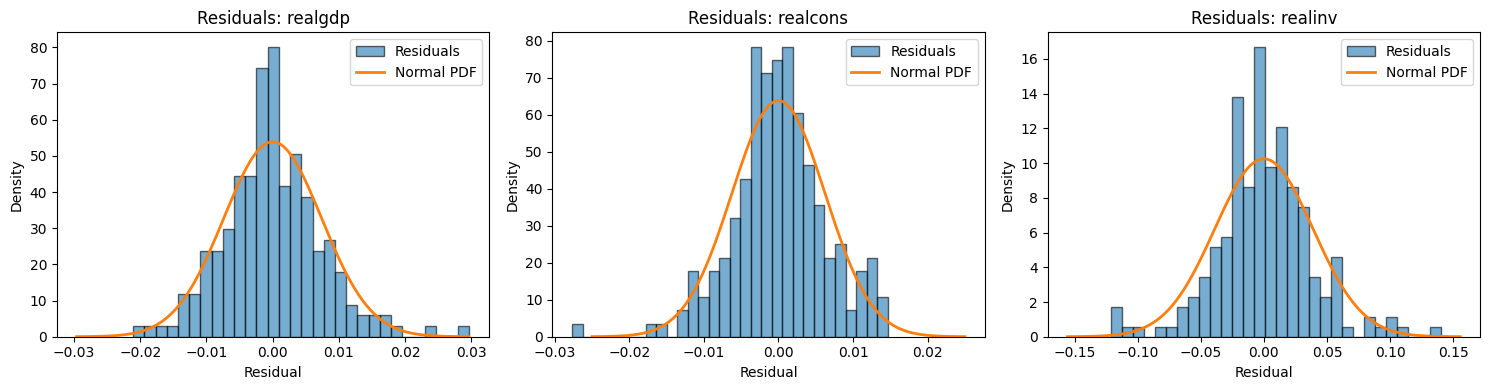

In [9]:
# ヒストグラムを用いて残差の正規性を分布で確認
import numpy as np
from scipy.stats import norm

residuals = results.resid
cols = residuals.columns

fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 4), tight_layout=True)

# 列が1つのときに axes をリスト扱いできるように調整
if len(cols) == 1:
    axes = [axes]

for ax, col in zip(axes, cols):
    series = residuals[col].dropna()
    
    # 残差の平均と標準偏差
    mu = series.mean()
    sigma = series.std(ddof=1)

    # ヒストグラム（確率密度としてプロット）
    ax.hist(series, bins=30, density=True, alpha=0.6, edgecolor="black", label="Residuals")

    # 正規分布の PDF を計算
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 200)
    y = norm.pdf(x, loc=mu, scale=sigma)

    # 正規分布の線を重ねる
    ax.plot(x, y, linewidth=2, label="Normal PDF")

    ax.set_title(f"Residuals: {col}")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Density")
    ax.legend()

plt.show()


-> ここでは、残差の正規性がひっかかったが、分布見るとそんなに歪ではないので、そのまま続ける

## 3-6. モデルの解釈
| 分析ツール | 問 | 解釈 |
| ---- | ---- | ---- |
| **グレンジャー因果性(Granger Causality)** | Xの**過去**は、Yの**未来**を予測するのに役立つか？ | 変数間の「予測関係」の有無(p値) |
| **インパルス応答関数(IRF)** | Xに1単位の**ショック**を与えたら、Yはどのように**反応(変化)**するか？ | ショックの「波及経路」と「持続時間」 |
| **予測誤差の分散分解(FEVD)** | Yの将来の**変動**(不確実性)は、どの変数の**ショック**によって**説明**されるか？ | 変動の「寄与度」・「要因分解」 |

### 3-6-1. グレンジャー因果性（Granger Causality）

* 目的：変数間の「予測上の」先行・遅行関係、すなわち情報の流れの方向性を特定
* 概念：「グレンジャー因果性（Granger Causality）」は、経済学的な意味での「AがBの原因である」という因果関係とは異なる。これは厳密には統計的な**「予測可能性」**に基づく概念。「変数Xが、変数Yをグレンジャー・コーズする（Granger-cause）」とは、
「Yの過去の値だけを使ってYの将来を予測するモデル」
よりも、
「Yの過去の値とXの過去の値の両方を使ってYの将来を予測するモデル」
の方が、予測精度が統計的に有意に向上する場合を指す。
VARモデルは、まさに「YとXの両方の過去の値」を使うモデル（$Y_t = \dots + A_i Y_{t-i} + \dots$）。したがって、VARモデルの推定結果を用いて、「Xの過去のラグ（例：$L1.X, L2.X, \dots$）の係数が、Yの方程式においてすべて同時に0である」という仮説を検定すれば、グレンジャー因果性の有無を判断できる。
* 仮説の設定：
    * 帰無仮説 (H0): "causing"（例: realinv）のラグ係数は、"caused"（例: realgdp）の方程式において全て0である。すなわち、"causing" は "caused" をグレンジャー・コーズしない。
    * 対立仮説 (H1): 係数の少なくとも1つは0ではない。すなわち、"causing" は "caused" をグレンジャー・コーズする。

In [11]:
# 検定１：relainv(投資)は、realgdp(GDP)をグレンジャーコーズするか？
print("\n--- Granger Causality Test: realinv -> realgdp ---")
# test_causality(caused_variable, causing_variables)
causality_test_1 = results.test_causality(
    caused="realgdp",
    causing="realinv"
)
print(causality_test_1)


--- Granger Causality Test: realinv -> realgdp ---
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: realinv does not Granger-cause realgdp: fail to reject at 5% significance level. Test statistic: 0.563, critical value: 2.621>, p-value: 0.640>


* p値：0.64 -> グレンジャーの因果性見られない

In [12]:
# 検定２：realinv(投資)とrealcons(消費)が、realgdp(GDP)をグレンジャーコーズするか？
print("\n--- Granger Causality Test: [realinv, realcons] -> realgdp ---")
causality_text_2 = results.test_causality(
    caused="realgdp",
    causing=["realinv", "realcons"]
)
print(causality_text_2)


--- Granger Causality Test: [realinv, realcons] -> realgdp ---
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['realinv', 'realcons'] do not Granger-cause realgdp: reject at 5% significance level. Test statistic: 7.000, critical value: 2.115>, p-value: 0.000>


* p値：0.00 -> グレンジャーの因果性見られる

#### 結果の見方
* p <= 0.05 の場合: 帰無仮説（因果性なし）を棄却。これは、「"causing"変数の過去の値は、"caused"変数の将来の予測精度を有意に向上させる」、すなわちグレンジャー因果性が存在すると結論付けられることを意味する。
* p > 0.05 の場合: 帰無仮説を棄却できない。統計的な証拠の観点からは、「"causing"変数が予測に役立つ」とは言えない、すなわちグレンジャー因果性は（このモデルでは）見られないと判断される。

<br>



### 3-6-2. インパルス応答関数(Impulse response Function - IRF)
* 目的：システム内の変数間の動的な「反応」と、その波及プロセスを視覚化。
* 概念：IRFは、「もしVARシステム内のある1つの変数に、1単位のショック（＝統計的に典型的な、誤差項$u_t$の1標準偏差分のランダムな変動）が一時的に発生したら、そのショックがシステム内の他のすべての変数に、**将来にわたって（何期後まで）**どのような影響（反応）を与えるか」をシミュレーションしたもの。これは、管理された実験（例：「もし景気（GDP）だけにポジティブなサプライズが起きたら、消費と投資はその後どう動くか？」）を、観測データ上のモデルで行うことに相当。


--- Impulse Response Function (IRF) ---


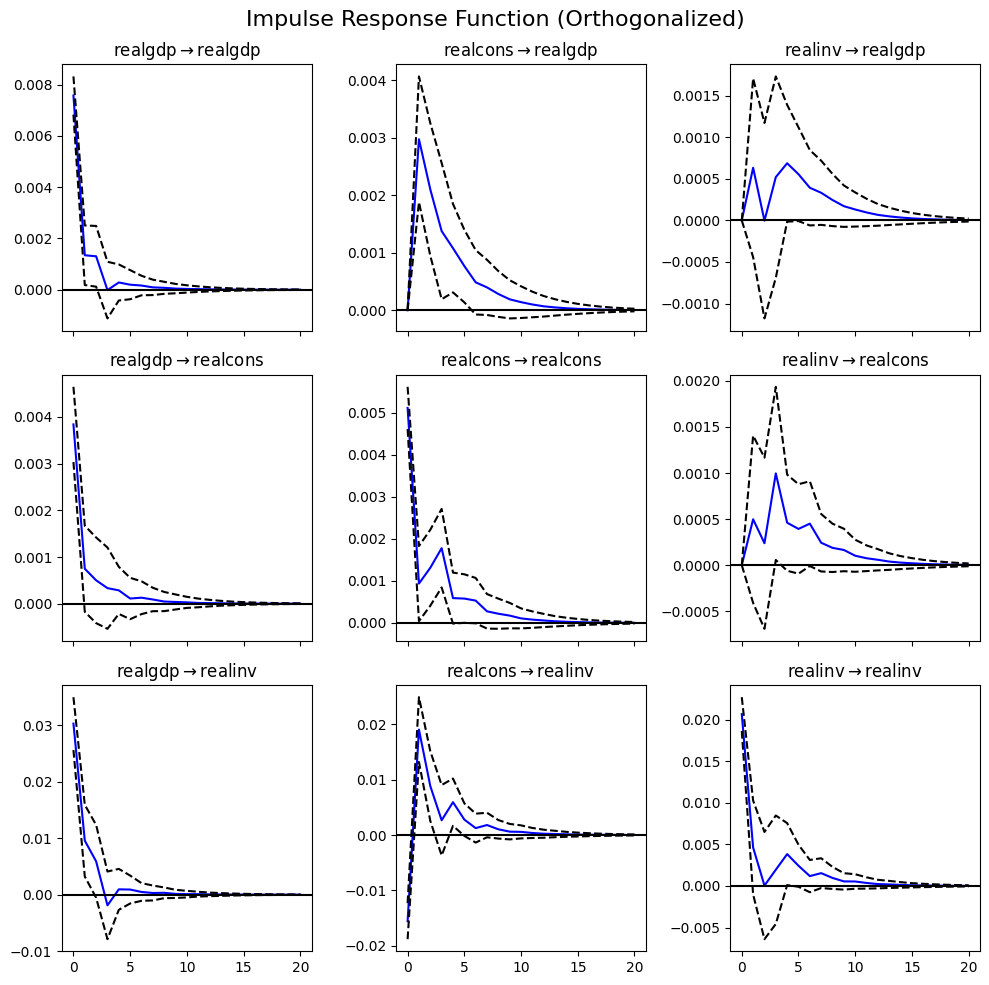

In [16]:
# 1. IRFの計算
# periods: 何期先までの反応を計算するか（例：20四半期 = 5年先）
irf = results.irf(periods=20)

# 2. IRFのプロット
# 基本的には、orth=Trueにして直交化IRFを使用する
# impulse: ショックを与える変数
# response: 反応を見る変数
# fig = irf.plot(impulse='realgdp', response='realcons', orth=True, signif=0.05)
# すべての組み合わせを一度にプロットすることも可能
# (K*K個のグラフが出力される）
print("\n--- Impulse Response Function (IRF) ---")
fig = irf.plot(orth=True, signif=0.05)
fig.suptitle("Impulse Response Function (Orthogonalized)", fontsize=16)
plt.tight_layout()
plt.show()

#### プロットの解釈
出力されるK\*K(ここでは、3\*3)個のグラフのマトリックスは、以下のように読み解く：
* グラフの行：Impulse (ショックを与えた変数）
* グラフの列：Response（反応を見た変数）

例えば、（行=realinv, 列=realgdp）のグラフは、「投資（realinv）に1標準偏差の正のショックを与えた場合の、GDP（realgdp）の反応」を示す。
* 横軸：ショック後の経過時間（0, 1, ..., 20期）
* 縦軸：応答変数（realgdp）の反応の大きさ（単位は標準偏差）
* 実線：応答の推定値（IRF）
* 点線の帯（信頼区間）：応答の不確実性（signif=0.05で95%信頼区間）

<br>

#### グラフの読み方（ストーリーの構築）
（行=realinv, 列=realgdp）のグラフを見て、実線が以下のように動いたとする。

    1. 0期目（ショック発生時）は0。
    2. 1期後から急速に上昇し、信頼区間の上側も0を上回る（=統計的に有意な正の反応）。
    3. 3期後に反応がピークに達する。
    4. その後、徐々に減衰し、10期後にはほぼ0に戻り、信頼区間も0をまたぐ（影響が消滅）。
    
このパターンから、「（このモデルによれば）投資が拡大するショックが発生すると、GDPは即座に反応しないが、1四半期後から有意に増加し始め、そのプラスの影響は約3四半期後に最大となり、約10四半期（2年半）かけて景気システムに吸収され、消滅していく」という、動的な物語を読み取れる。

<br>

#### ※ IRFプロットの注意点 orth=True(直交化IRF)の指定
* 問題：VARモデルの誤差項（$u_t$）は、現実には互いに相関している（例：景気が良くなるショック($u_{gdp}$)と、消費マインドが上がるショック($u_{cons}$)は、同時に発生しがち）。この相関を無視して「GDPだけにショック」を与えるシミュレーション（orth=False）は非現実的。
* 解決策（直交化）：直交化IRFは、この同時相関の問題を解決するための標準的な手法。具体的には、コレスキー分解を用いて、相関のある誤差項 $u_t$ を、互いに相関しない（直交する）「構造的なショック」$\epsilon_t$ に分解する。
* 注意点：**※ ｋコレスキー分解は、VAR(data)に渡したdataの変数の順序に依存する。** data = mdata\[\['realgdp', 'realcons', 'realinv']] という順番でモデルを構築した場合、コレスキー分解は暗黙的に以下の理論的な仮定を置いている。
    1. realgdp（1番目）のショックは、**同期間に**realcons（2番目）とrealinv（3番目）に影響を与える**ことができる**。
    2. realcons（2番目）のショックは、**同期間に**realinv（3番目）に影響を与えることができるが、realgdp（1番目）には影響を与え**ない**。
    3. realinv（3番目）のショックは、**同期間に**realgdpとrealconsのどちらにも影響を与え**ない**。

（今回の仮定は、「景気（GDP）は消費や投資に即時影響するが、投資が景気に即時影響することはない」という経済理論的な過程に基づいている。）

##### ※ inf.plot(orth=True)を単に実行するだけでなく、VARに渡す**変数の順序が、分析対象のドメイン知識（経済学、ビジネス理論）と整合的であるか**を常に自問し、その順序を（あるいは順序を入れ替えた場合の頑健性を）正当化できなければならない。

<br>


### 3-6-3. 予測誤差の分散分解（Forecast Error Variance Decompositon - FEVD）
* 目的：各変数の将来の変動（不確実性）が、どの変数のショックによって引き起こされているかを定量的に評価する。
* 概念：ある変数（例：realgdp）の$h$期先の予測値を考える。この予測には、将来の予期せぬショック（$u_{t+1}, \dots, u_{t+h}$）により、必ず「予測誤差」が伴う。この「予測誤差の分散（=予測の不確実性の大きさ）」は、システム内の各変数（realgdp, realcons, realinv）のショックによって引き起こされた部分に分解することができる。FEVDは、この文化結果を**パーセンテージ**で示す。例えば、「$h=20$期先のGDPの不確実性のうち、何％がGDP自身のショック、何％が消費のショック、何％が投資のショックに起因するか？」を明らかにする。




--- Forecast Error Variance Decompositon (FEVD) ---


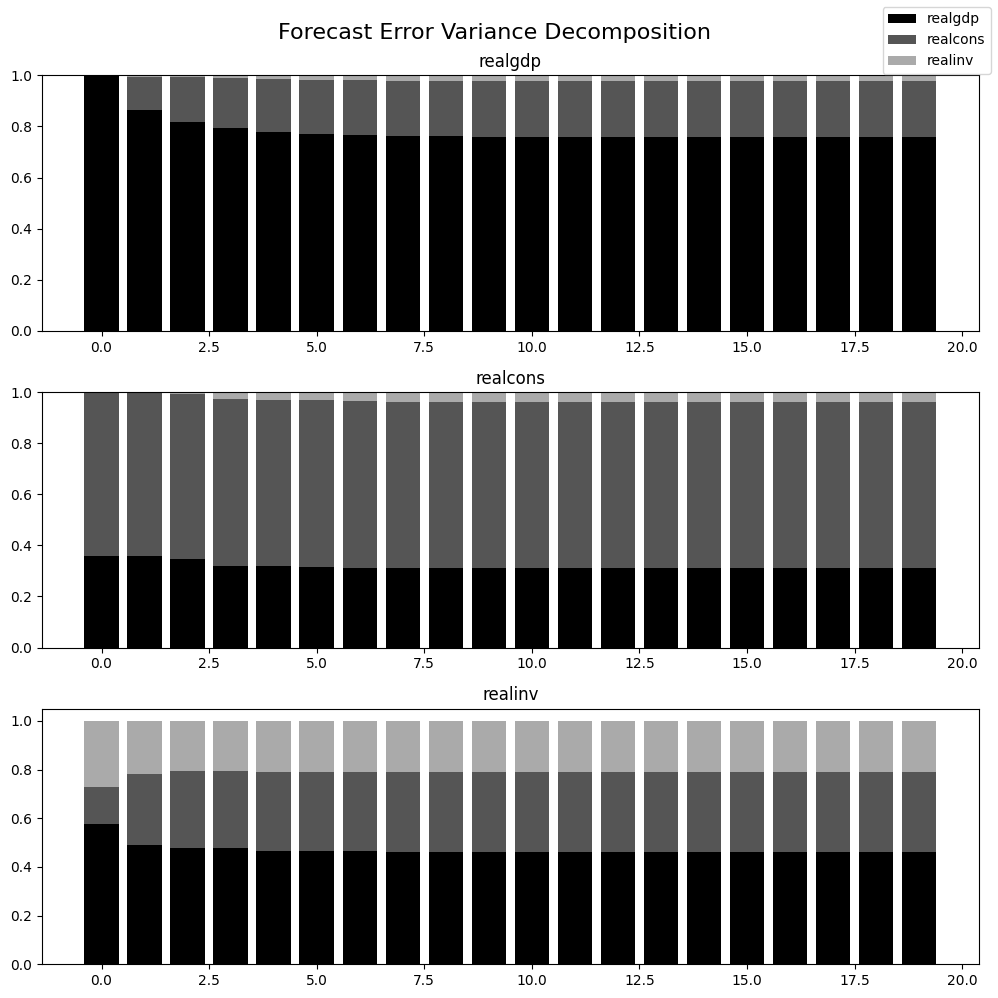

In [17]:
# 1. FEVDの計算
# periods:何期先までの分解を計算するか
fevd = results.fevd(periods=20)

# 2. FEVDのプロット
# K個のグラフ（各変数の分解結果）が出力される
print("\n--- Forecast Error Variance Decompositon (FEVD) ---")
fig = fevd.plot()
fig.suptitle("Forecast Error Variance Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

#### プロットの解釈
出力されるグラフは、応答変数ごと（FEVD for realgdp, FEVD for realcons, ...）に表示される。

FEVD for realgdp（GDPの変動の要因分解）のグラフに着目すると。

* 横軸：予測期間（1期先, ... , 20期先）
* 縦軸：予測誤差の分散（合計100％）
* 積み上げ棒グラフの各色：各色の面積が、その変数のショックによる寄与度（％）を示す。（凡例で色がどの変数に対応するか確認）

<br>

#### グラフの読み方（ストーリーの構築）
(FEVD for realgdp)のグラフが以下のように見えたとする。
1. **1期先（短期）**：realgdpのショック（例：青色）がほぼ100％を占める。
2. **20期先（長期）**：横軸が進むにつれて青色の面積が減少し、realcons（オレンジ色）と realinv（緑色）の面積が増加する。最終的に、realgdpショックが70％、realconsショックが20%、realinvショックが10％を占めるようになる。


このパターンから、「（このモデルによれが）**短期的**なGDPの変動（不確実性）は、ほぼGDP自身の予期せぬ要因によって決まる。しかし、**長期的**（20期先）に見ると、GDPの変動の30％（消費20％+投資10％）は、消費や投資の予期せぬショックによって引き起こされている」と結論づけられる。


#### FEVDの応用（内生性の度合い）：
FEVDは、システム内での変数の「内生性」を測る強力な指標にもなりえる。

* **「外生的」な変数**：ある変数のFEVDが、長期的に見ても**自身のショック**によって90％以上説明される場合、その変数はシステム内の他の変数からほとんど影響を受けておらず、「外生的」に動いている可能性が高い。
* **「内生的」な変数**：逆に、他の変数からのショックによって変動の多く（例：50％以上）が説明される変数は、システム内で「内生的」に動いている（＝他の変数の影響を強く受けている）と居える。